In [ ]:
import os
import cv2
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model

from keras.utils import np_utils

In [ ]:
INPUT_PATH = "../input/fer13-cleaned-dataset/"

In [ ]:
total_images = 0
for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
        total_images += 1
    print(f"{dir_} has {count} number of images")

print(f"\ntotal images are {total_images}")

Happy has 6834 number of images
disgust has 380 number of images
Neutral has 4295 number of images
fear has 2535 number of images
Angry has 2832 number of images

total images are 16876


In [ ]:
TOP_EMOTIONS = ["fear", "Happy", "Neutral", "Angry"]
total_images -= 380
total_images

16496

In [ ]:
img_arr = np.empty(shape=(total_images,48,48,3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img_arr[i] = cv2.imread(INPUT_PATH + dir_ + "/" + f)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

img_arr.shape, img_label

loaded all Happy images to numpy arrays
loaded all Neutral images to numpy arrays
loaded all fear images to numpy arrays
loaded all Angry images to numpy arrays


((16496, 48, 48, 3), array([0., 0., 0., ..., 3., 3., 3.]))

In [ ]:
label_to_text

{0: 'Happy', 1: 'Neutral', 2: 'fear', 3: 'Angry'}

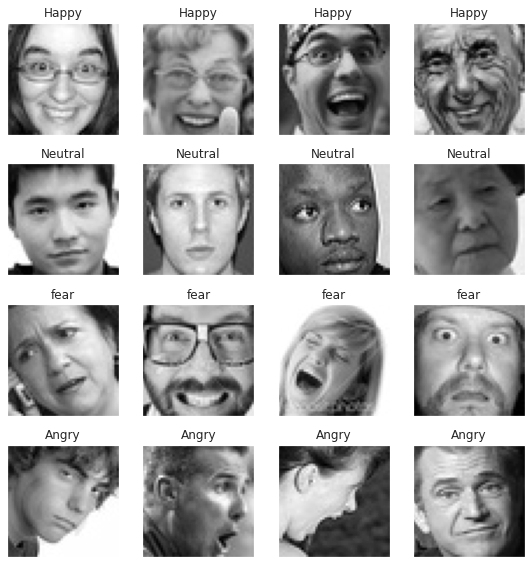

In [ ]:
fig = pyplot.figure(1, (8,8))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label==k)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(4,4,idx)
        ax.imshow(img[:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [ ]:
img_label = np_utils.to_categorical(img_label)
img_label.shape

(16496, 4)

`Splitting the data into training and validation set.`

In [ ]:
img_arr = img_arr / 255.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.9, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14846, 48, 48, 3), (1650, 48, 48, 3), (14846, 4), (1650, 4))

In [ ]:
del img_arr
del img_label

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
mobile_net = MobileNet(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
out = Dense(num_classes, activation="softmax", name="out_layer")(global_pool)

model = Model(inputs=mobile_net.input, outputs=out)

/opt/conda/lib/python3.6/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


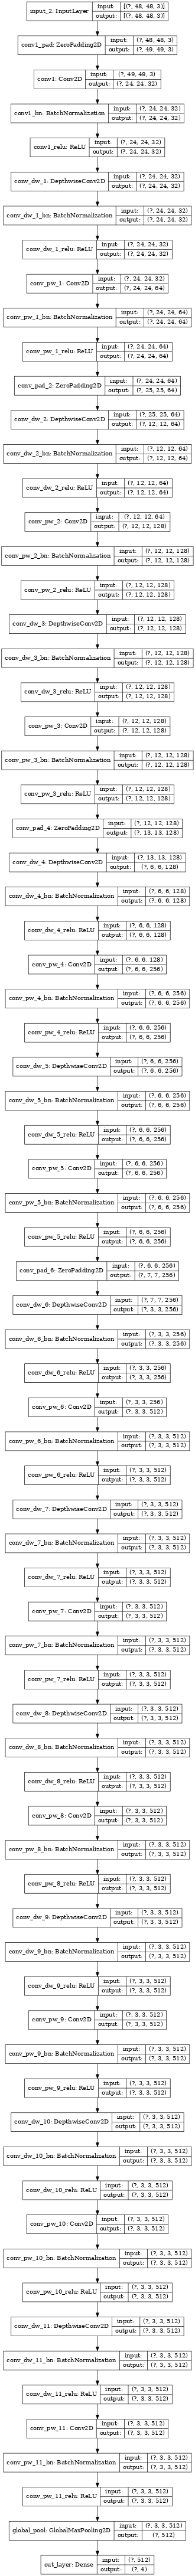

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='mobilenet.png')

In [ ]:
for layer in model.layers[:15]:
    layer.trainable = False

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
train_datagen.fit(X_train)

In [ ]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [ ]:
batch_size = 25
epochs = 40

optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    optimizers.Adam(0.01),
]

model.compile(
        loss='categorical_crossentropy',
        optimizer=optims[1],
        metrics=['accuracy']
)

history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Train for 593.84 steps, validate on 1650 samples
Epoch 1/40
594/593 [==============================] - 20s 34ms/step - loss: 1.3397 - accuracy: 0.4801 - val_loss: 1.2709 - val_accuracy: 0.5818
Epoch 2/40
594/593 [==============================] - 16s 28ms/step - loss: 1.0048 - accuracy: 0.5975 - val_loss: 0.9499 - val_accuracy: 0.6236
Epoch 3/40
594/593 [==============================] - 15s 26ms/step - loss: 0.9296 - accuracy: 0.6242 - val_loss: 0.9510 - val_accuracy: 0.6321
Epoch 4/40
594/593 [==============================] - 19s 31ms/step - loss: 0.8795 - accuracy: 0.6474 - val_loss: 1.1673 - val_accuracy: 0.5758
Epoch 5/40
594/593 [==============================] - 17s 29ms/step - loss: 0.8610 - accuracy: 0.6565 - val_loss: 0.8520 - val_accuracy: 0.6727
Epoch 6/40
594/593 [==============================] - 17s 29ms/step - loss: 0.8454 - accuracy: 0.6619 - val_loss: 0.8168 - val_accuracy: 0.6788
Epoch 7/40
594/593 [==============================] - 18s 31ms/step - loss: 0.8256 - ac

In [ ]:
model_yaml = model.to_yaml()
with open("model_mobelnet.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

model.save("model_moblenet.h5")

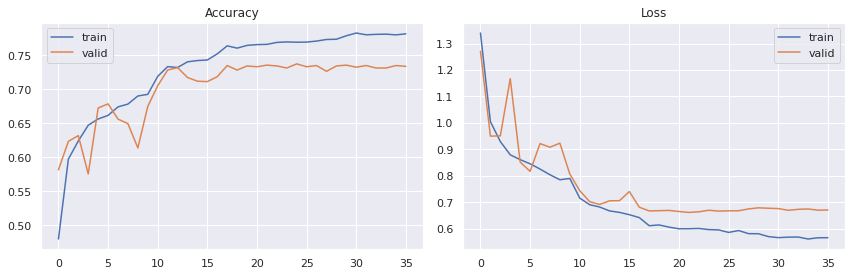

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_mobilenet.png')
pyplot.show()

In [ ]:
label_to_text

{0: 'Happy', 1: 'Neutral', 2: 'fear', 3: 'Angry'}

In [ ]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'Happy': 0, 'Neutral': 1, 'fear': 2, 'Angry': 3}

test accuracy: 73.7576 %


              precision    recall  f1-score   support

           0       0.83      0.91      0.87       684
           1       0.67      0.70      0.68       430
           2       0.67      0.59      0.63       253
           3       0.65      0.51      0.57       283

    accuracy                           0.74      1650
   macro avg       0.70      0.68      0.69      1650
weighted avg       0.73      0.74      0.73      1650



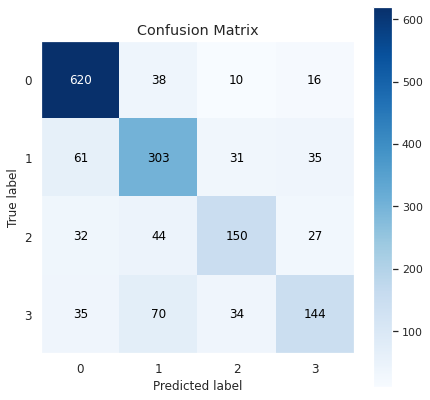

In [ ]:
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("confusion_matrix_mobilenet.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

The confusion matrix clearly shows that our model is doing good job on the class `happy` but it's performance is not that good on other classes. One of the reason for this could be the fact that these classes have less data as compared to `happy`.

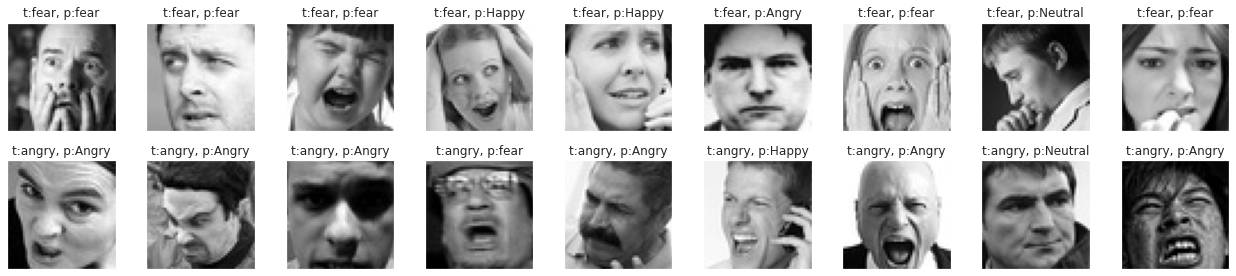

In [ ]:
np.random.seed(42)
fear_imgs = np.random.choice(np.where(y_test[:, text_to_label["fear"]]==1)[0], size=9, replace=False)
angry_imgs = np.random.choice(np.where(y_test[:, text_to_label["Angry"]]==1)[0], size=9, replace=False)

fig = pyplot.figure(1, (18, 4))

for i, (fear_idx, angry_idx) in enumerate(zip(fear_imgs, angry_imgs)):
        sample_img = X_test[fear_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:fear, p:{pred}")

        sample_img = X_test[angry_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+10)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:angry, p:{pred}")

        pyplot.tight_layout()